<a href="https://colab.research.google.com/github/JUNYA-727/MASKRCNN-clack-detection/blob/main/clack_detect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import os
import glob 
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import zipfile

In [3]:
with zipfile.ZipFile('/content/IMAGES 2.zip','r') as f:
  f.extractall('IMAGES')

In [4]:
img_path='/content/IMAGES/IMAGES/train/images/7002-67.jpg'
json_path='/content/IMAGES/IMAGES/train/images/7002-67.json'


In [5]:
#マスク画像と通常の画像の振り分け用のフォルダ作成
os.makedirs('/content/dataset')
os.makedirs('/content/dataset/train')
os.makedirs('/content/dataset/train/image')
os.makedirs('/content/dataset/train/mask')
os.makedirs('/content/dataset/valid')
os.makedirs('/content/dataset/valid/image')
os.makedirs('/content/dataset/valid/mask')

In [6]:
train_json_list=glob.glob('/content/IMAGES/IMAGES/train/images/*.json')
valid_json_list=glob.glob('/content/IMAGES/IMAGES/valid/images/*.json')

In [ ]:
train_json_list[0:3]

In [8]:
#jsonからマスク化した画像の保存及び､データの前準備
def make_mask(json_list,save_dir):
  for json_path in json_list:
    with open(json_path) as f:
      data=json.loads(f.read())
    shapes=data['shapes']
    points=[]
    for shape in shapes:
      label=shape['label']
      point=shape['points']
      points.append(point)
      shape_type=shape['shape_type']
      image_path=json_path.replace('json','jpg')
      img=cv2.imread(image_path)
    mask=np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
    for _ in range(len(points)):
      mask=cv2.fillPoly(mask,np.int32([points[_]]),1)
    mask_img=np.clip(mask*255,a_min=0,a_max=255).astype(np.uint8)
    save_image_path=os.path.join(save_dir,'image',(image_path.split('/')[-1]))
    save_mask_path=os.path.join(save_dir,'mask',(image_path.split('/')[-1]))
    cv2.imwrite(save_image_path,img)
    cv2.imwrite(save_mask_path,mask_img)

In [9]:
make_mask(train_json_list,save_dir='/content/dataset/train')

In [10]:
make_mask(valid_json_list,save_dir='/content/dataset/valid')

In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

In [ ]:
!pip install -r '/content/Mask-RCNN-TF2/requirements.txt'

In [7]:
cd /content/Mask-RCNN-TF2

/content/Mask-RCNN-TF2


In [12]:
import tensorflow 
import keras
import skimage
from mrcnn import utils
import pathlib
from PIL import Image
import copy
from mrcnn.config import Config
import mrcnn.model
import urllib.request

In [9]:
class OneClassConfig(Config):
  NAME='clack_dataset'

  IMAGES_PER_CPU=1

  NUM_CLASSES=2

  STEP_PER_EPOCH=50

  DETECTION_MIN_CONFIDENCE = 0.9

In [10]:
class OneClassDataset(utils.Dataset):
  def load_dataset(self,dataset_dir):
    self.add_class('clack_dataset',1,'clack')
    images=glob.glob(os.path.join(dataset_dir,'image','*.jpg'))
    masks=glob.glob(os.path.join(dataset_dir,'mask','*.jpg'))
    for image_path,mask_path in zip(images,masks):
      image_path=pathlib.Path(image_path)
      mask_path=pathlib.Path(mask_path)
      assert image_path.name==mask_path.name,'データセットがずれています'
      image=Image.open(image_path)
      height=image.size[0]
      width=image.size[1]
      mask=Image.open(mask_path)
      assert image.size==mask.size,'サイズがずれています'
      self.add_image(
          'clack_dataset',
          path=image_path,
          image_id=image_path.stem,
          mask_path=mask_path,
          width=width,height=height
      )
  def load_mask(self,image_id):
    image_info=self.image_info[image_id]
    if image_info['source']!='clack_dataset':
      return super(self.__class__,self).load_mask(image_id)
    mask_path = image_info['mask_path']
    mask, cls_idxs = blob_detection(str(mask_path))

    return mask, cls_idxs
  def image_reference(self, image_id):
      info = self.image_info[image_id]
      if info["source"] == 'clack_dataset':
          return info
      else:
          super(self.__class__, self).image_reference(image_id)
def blob_detection(mask_path):
    mask = cv2.imread(mask_path, 0)
    _, mask = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)

    label = cv2.connectedComponentsWithStats(mask)
    data = copy.deepcopy(label[1])

    labels = []
    for label in np.unique(data):
        if label == 0:
            continue
        else:
            labels.append(label)

    mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)

    for n, label in enumerate(labels):
        mask[:, :, n] = np.uint8(data == label)

    cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32)

    return mask, cls_idxs

In [14]:
TRAIN_DATASET='/content/dataset/train'
dataset_train=OneClassDataset() 
dataset_train.load_dataset(TRAIN_DATASET)
dataset_train.prepare()
VALID_DATASET='/content/dataset/valid'
dataset_val=OneClassDataset()
dataset_val.load_dataset(VALID_DATASET)
dataset_val.prepare()
config=OneClassConfig()
model = mrcnn.model.MaskRCNN(mode="training", config=config,
                          model_dir='/content/models')
urllib.request.urlretrieve('https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5','mask_rcnn_coco.h5')
COCO_MODEL_PATH = 'mask_rcnn_coco.h5'
model.load_weights(COCO_MODEL_PATH, by_name=True,
                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])


In [15]:
#学習開始
model.train(dataset_train, dataset_val,
            learning_rate=0.001,
            epochs=10,
            layers='heads')

1000/1000 [==============================] - 579s 579ms/step - loss: 0.1187 - val_loss: 0.9423


In [16]:
model.keras_model.save_weights("/content/mask_rcnn.h5")

In [17]:
model.load_weights(filepath='/content/mask_rcnn.h5',by_name=True)

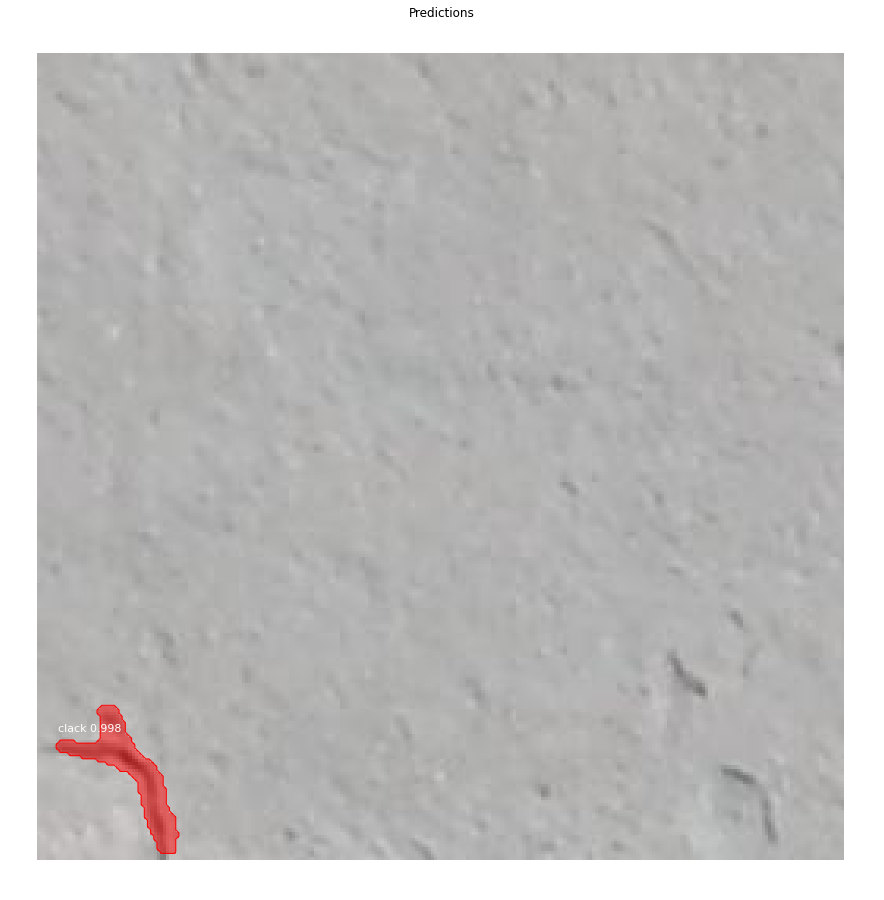

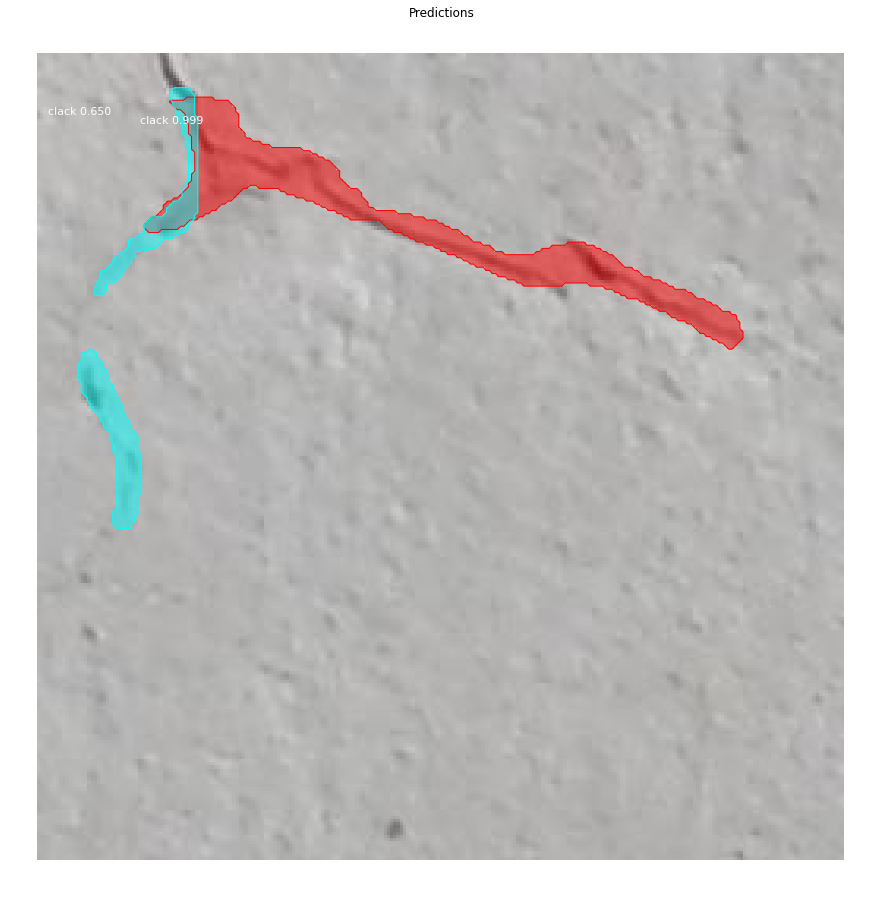

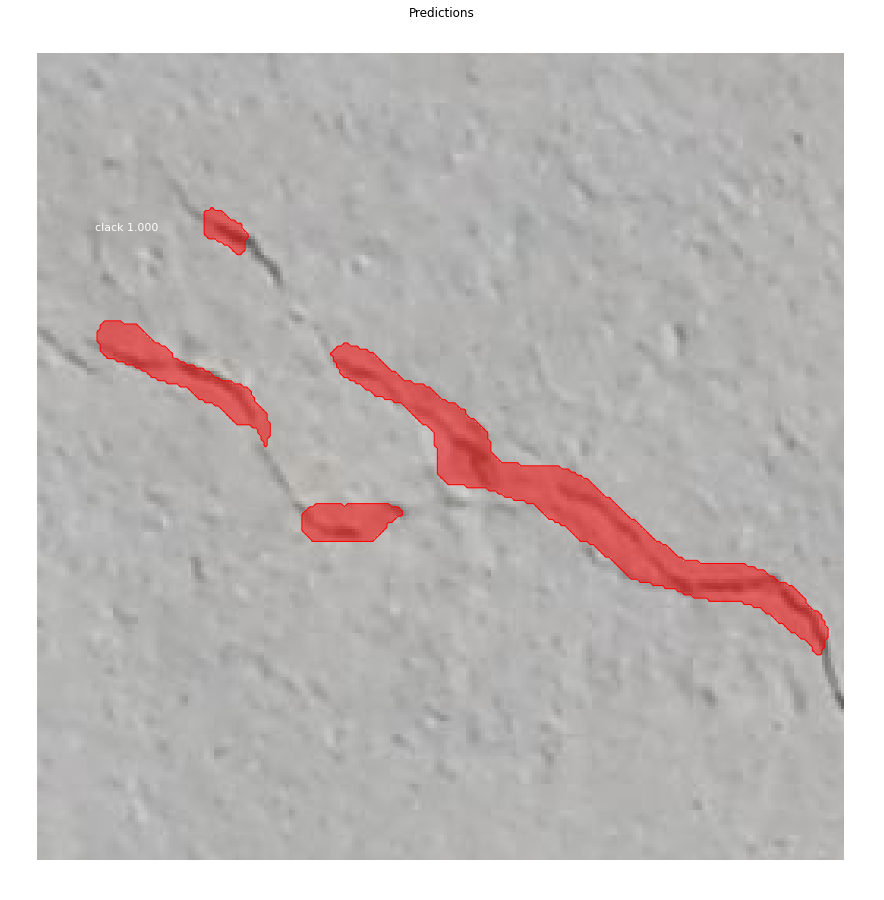

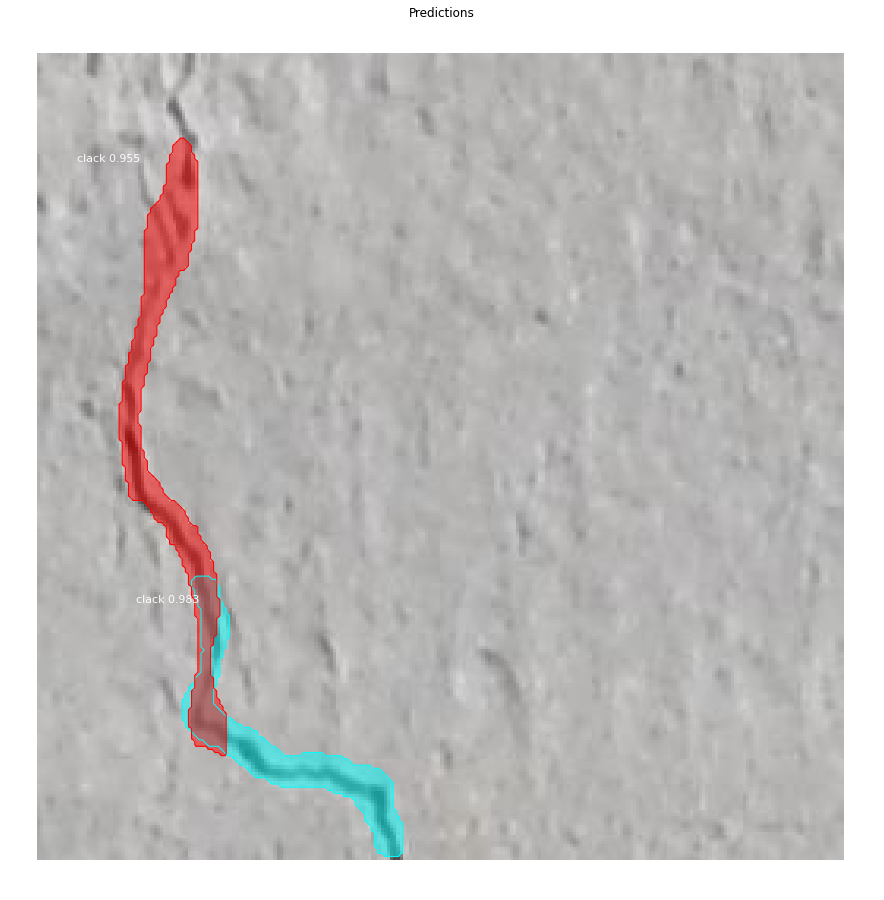

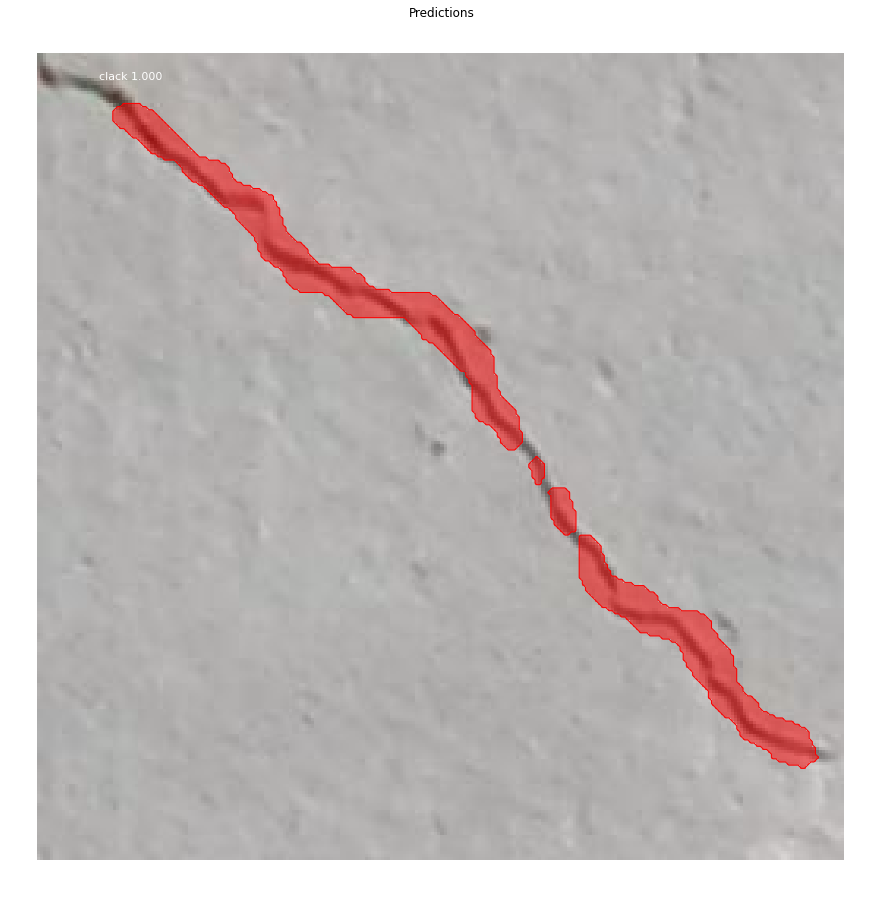

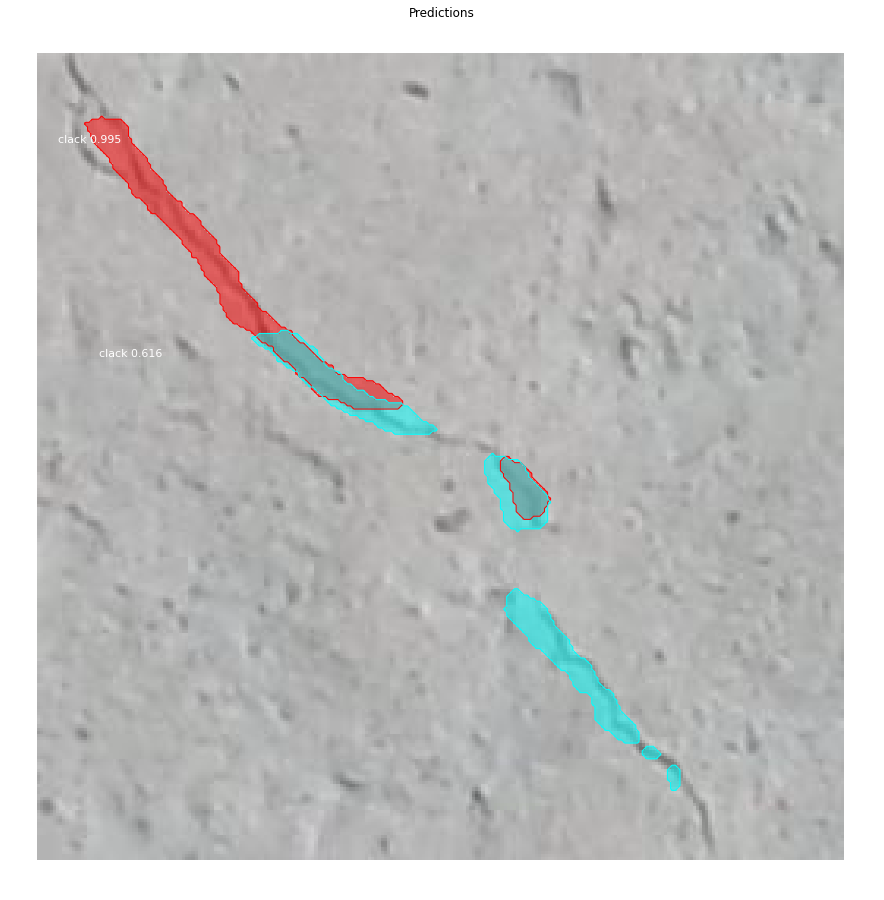


*** No instances to display *** 



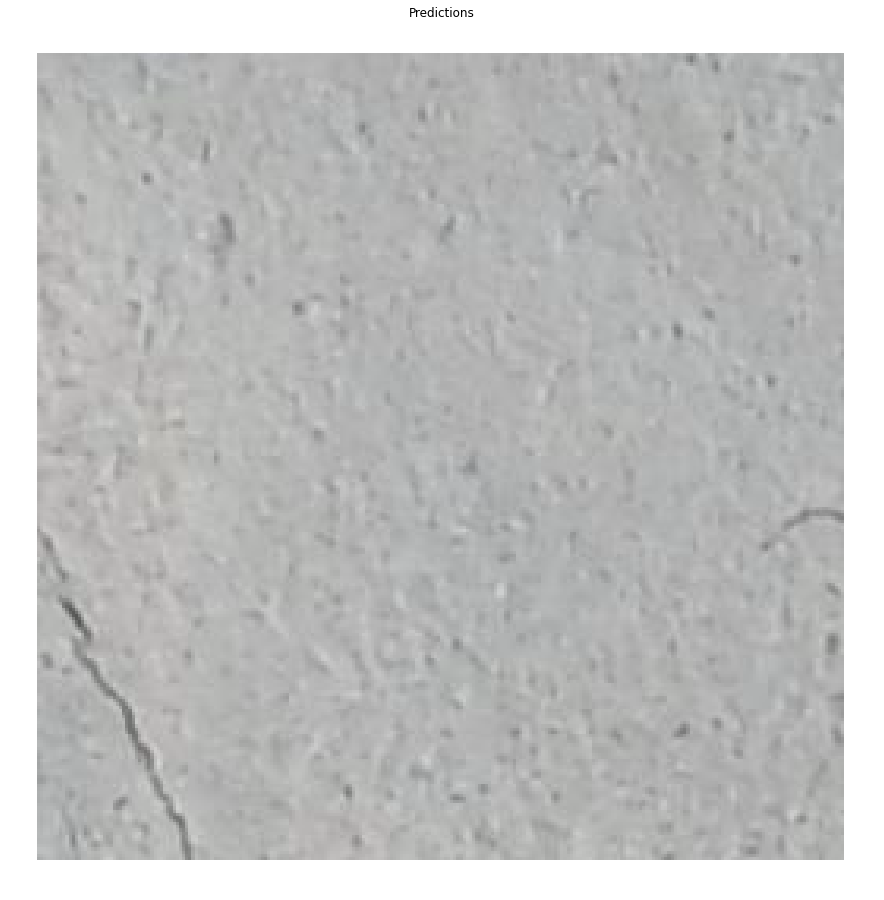

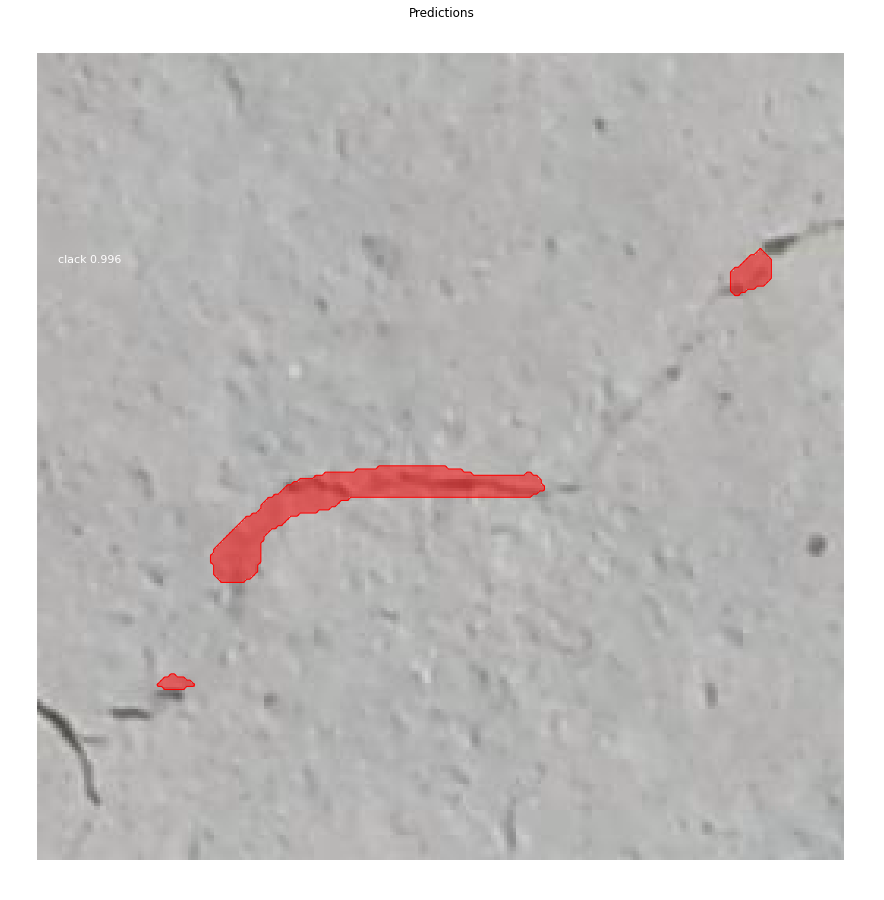

In [37]:
from numpy.lib.npyio import save
from mrcnn import visualize

class InferenceConfig(OneClassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
config = InferenceConfig()
model = mrcnn.model.MaskRCNN(mode="inference", config=config,
                          model_dir=None)
model.load_weights('/content/mask_rcnn.h5', by_name=True)
valid_path=glob.glob('/content/dataset/valid/image/*.jpg')
class_name=['none','clack']
for path in valid_path:
  image=cv2.imread(path)
  r=model.detect([image])
  r=r[0]
  mrcnn.visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],class_name,r['scores'],show_bbox=False,title="Predictions",save_fig_path='/content/dataset/predict/',)
